**Importation de la base de donnée**


In [ ]:
from google.colab import files
import pandas as pd
import io
#importation de la base de donnée counts_in by hour
uploaded = files.upload()
data1 = pd.read_csv(io.BytesIO(uploaded['Data_counts_in.csv']))
data1.drop('Id', inplace=True, axis=1)
data1.head()

In [ ]:
#importation de la base de donnée counts_out by hour
uploaded = files.upload()
data2 = pd.read_csv(io.BytesIO(uploaded['Data_counts_out.csv']))
data2.drop('Id', inplace=True, axis=1)
data2.head()

In [ ]:
data1["Date_day"] = pd.to_datetime(data1["Date_day"])
data2["Date_day"] = pd.to_datetime(data2["Date_day"])
data2.dtypes

In [ ]:
data = pd.merge(data1, data2, left_on=('Date_day','hour'), right_on=('Date_day','hour'), how="left")
data      

In [ ]:
# all libraries i need for the model
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import math
import seaborn as sns 
import pandas as pd 
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
le = preprocessing.LabelEncoder()

In [ ]:
data.corr()
import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
seaborn.heatmap(data.corr(),annot = True ,cmap="coolwarm")

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.lineplot(x=data.Date_day, y=data.counts_out.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Counts_out', fontsize=14)
ax[0].set_ylabel(ylabel='Counts_out', fontsize=14)


sns.lineplot(x=data.Date_day, y=data.counts_in.fillna(np.inf), ax=ax[1], color='dodgerblue')
ax[1].set_title('Target: Counts_in', fontsize=14)
ax[1].set_ylabel(ylabel='Counts_in', fontsize=14)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(data['counts_in'])
def adfuller_test(counts_in):
    result=adfuller(counts_in)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['counts_in'])


In [ ]:
data['counts_in First Difference'] = data['counts_in'] - data['counts_in'].shift(1)
data['Seasonal First Difference']=data['counts_in']-data['counts_in'].shift(12)
data.head()

In [ ]:
#testing if data is stationary
adfuller_test(data['Seasonal First Difference'].dropna())



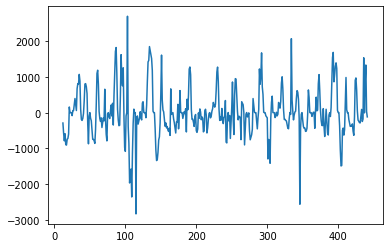

In [ ]:
data['Seasonal First Difference'].plot()

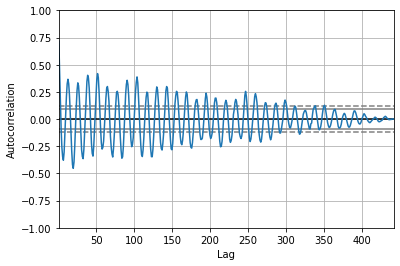

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['counts_in'])
plt.show()

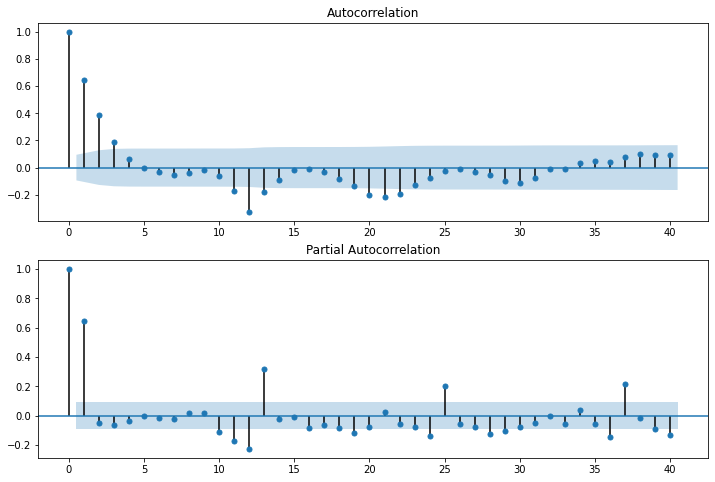

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data['counts_in'],order=(1,1,0))
model_fit=model.fit(disp=0)
model_fit.summary()

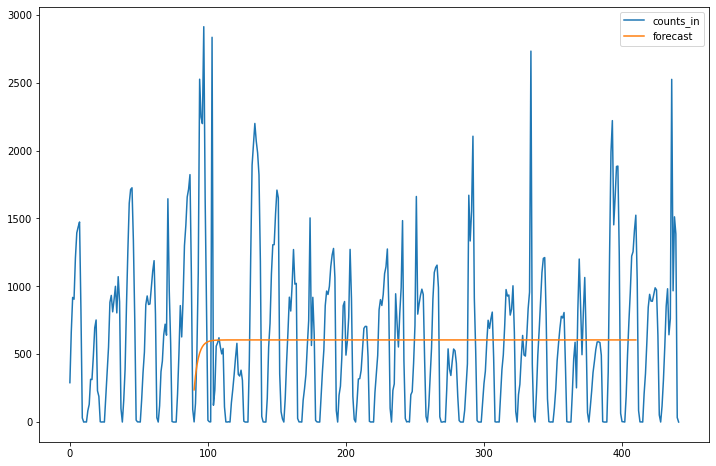

In [ ]:
data['forecast']=model_fit.predict(start=90,end=410,dynamic=True)
data[['counts_in','forecast']].plot(figsize=(12,8))

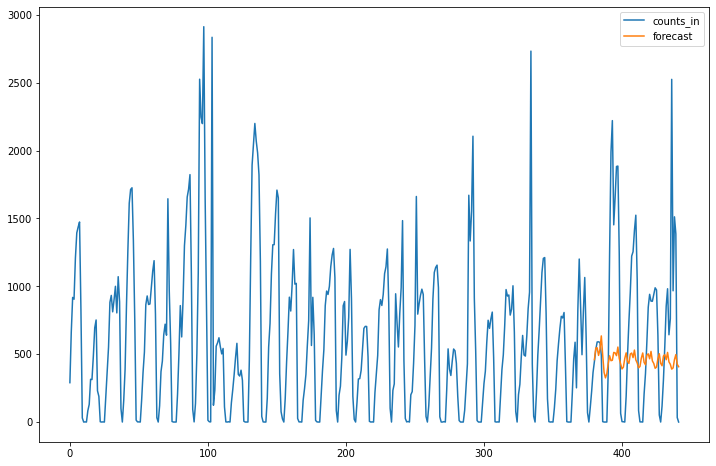

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['counts_in'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=380,end=500,dynamic=True)
data[['counts_in','forecast']].plot(figsize=(12,8))

In [ ]:
X = np.array([data['hour'],data['counts_in'],data['Real_effectif'],data['day'],data['month'],
              data['year']])
y = np.array(data['counts_out'])
X = X.transpose()
y = np.array(y).reshape(-1,1)
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [ ]:
y.shape

In [ ]:
# Fractionnement de l'ensemble de données en ensemble d'apprentissage et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape

In [ ]:

# Initialiser le modèle
model = Sequential()

# Ajouter la première couche de l'entrée avec 4 neurones d'entrée 
# et la première couche cachée avec 6 neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='sigmoid', input_dim=6),
    tf.keras.layers.Dense(1 , activation='sigmoid')])



model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.MeanSquaredError() , metrics=['accuracy'])
print("Entrainement avec l'algorithme Adam")

history = model.fit(X_train, y_train, batch_size = 10, epochs = 100)

loss = history.history.get('loss')
accuracy = history.history.get('accuracy')
val_loss = history.history.get('val_loss')
val_accuracy = history.history.get('val_accuracy')


In [ ]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(accuracy , "b")
#plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(loss, "r")
#plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

In [ ]:
#Calcul MSE
import math
from sklearn import metrics
pred = model.predict(X)
score = np.sqrt(metrics.mean_squared_error(y,pred))
print("Une seule couche cachée C1")
print("La valeur MSE de notre modèle avec l'algorithme Adam")
print("MSE = {} ".format(score))
print("RMSE = {} ".format(np.sqrt(score)))
print("Accuracy = ", 1-np.sqrt(score))

Une seule couche cachée C1
La valeur MSE de notre modèle avec l'algorithme Adam
MSE = 0.7801985999424951 
RMSE = 0.8832885145537075 
Accuracy =  0.1167114854462925


La valeur R² de l apprentissage : [0.43998889]
La valeur R² du test : [0.21213532]


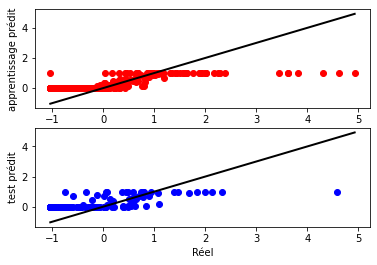

In [ ]:
y_predicted = model.predict(X_train)
fig, (ax1,ax2) = plt.subplots(2)
ax1.scatter(y_train, y_predicted , color ='red')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax1.set_xlabel('apprentissage actuel')
ax1.set_ylabel('apprentissage prédit')
print('La valeur R² de l apprentissage : ' + str(r2_score(y_train, y_predicted , multioutput='raw_values')))

y_predicted2= model.predict(X_test)
ax2.scatter(y_test, y_predicted2 , color ='blue')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=2)
ax2.set_xlabel('Réel')
ax2.set_ylabel('test prédit')

print('La valeur R² du test : ' + str(r2_score(y_test, y_predicted2 , multioutput='raw_values')))

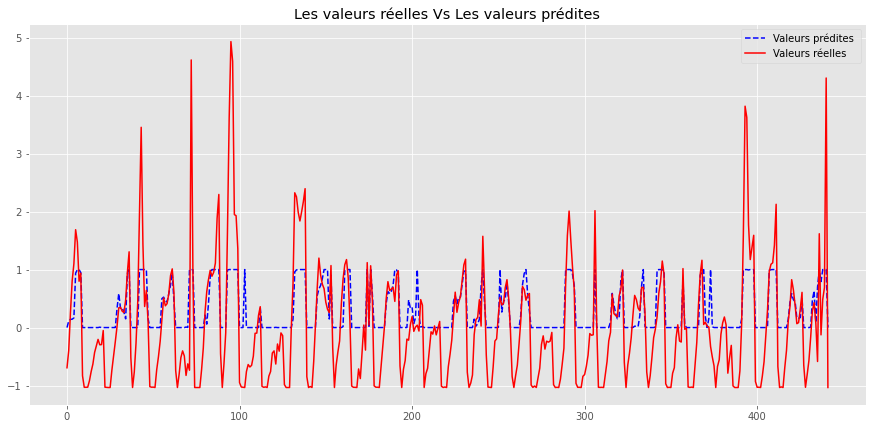

In [ ]:
#Le traçage des valeurs réelles Vs prédites
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

plt.plot(pred ,"b--",label='Valeurs prédites ')
plt.plot(y,"r",label='Valeurs réelles')

plt.title('Les valeurs réelles Vs Les valeurs prédites')
plt.legend()
plt.show()

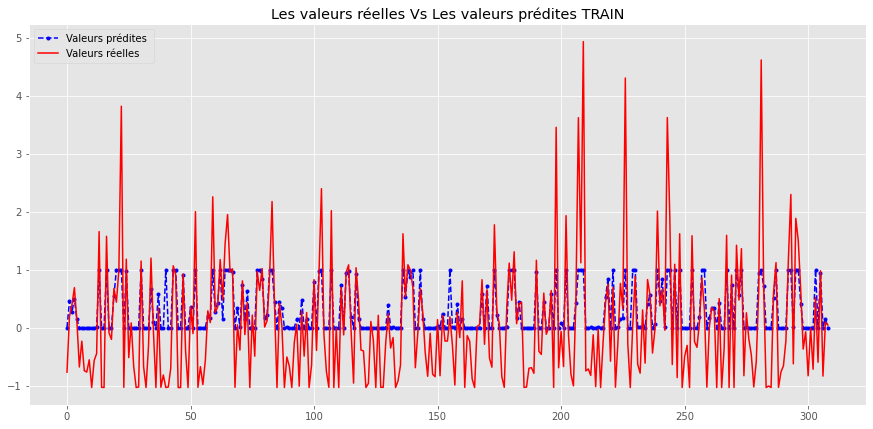

In [ ]:
#Le traçage des valeurs réelles Vs prédites TRAIN
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

plt.plot(y_predicted ,"b.--",label='Valeurs prédites ')
plt.plot(y_train,"r",label='Valeurs réelles')

plt.title('Les valeurs réelles Vs Les valeurs prédites TRAIN')
plt.legend()
plt.show()

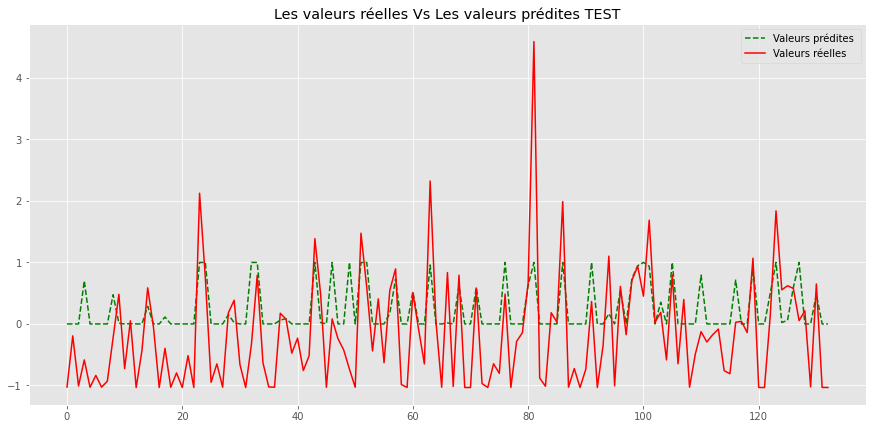

In [ ]:
#Le traçage des valeurs réelles Vs prédites TEST
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

plt.plot(y_predicted2 ,"g--",label='Valeurs prédites ')
plt.plot(y_test,"r",label='Valeurs réelles')

plt.title('Les valeurs réelles Vs Les valeurs prédites TEST')
plt.legend()
plt.show()

In [ ]:
# all libraries i need for the model
import tensorflow as tf
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
le = preprocessing.LabelEncoder()

In [ ]:
from google.colab import files
import pandas as pd
import io
#importation de la base de donnée counts_in by hour
uploaded = files.upload()
data1 = pd.read_csv(io.BytesIO(uploaded['Data_counts_in.csv']))
data1.drop('Id', inplace=True, axis=1)
data1.head()

Saving Data_counts_in.csv to Data_counts_in.csv


,Date_day,hour,counts_in
0,2021-05-04,9,290
1,2021-05-04,10,662
2,2021-05-04,11,918
3,2021-05-04,12,905
4,2021-05-04,13,1208


In [ ]:
X = np.array([data1['hour'],data['counts_in'],data['Real_effectif'],data['day'],data['month'],
              data['year']])
y = np.array(data['counts_out'])
X = X.transpose()
y = np.array(y).reshape(-1,1)
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)